In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from typing import Tuple, List

import warnings
warnings.filterwarnings("ignore")

In [2]:
# constants
TRAIN_START = '2002-01-01'
TRAIN_END = '2012-12-31'
TEST_START = '2013-01-01'
TEST_END = '2024-09-01'

In [3]:
snp500 = pd.read_csv('../../src/data/snp500.csv')
sectors = snp500.groupby('sector')
sector_tickers = {sector[0]: sector[1]['ticker'].tolist() for sector in sectors}

In [4]:
prices = yf.download(snp500['ticker'].tolist(), start=TRAIN_START, end=TRAIN_END)['Adj Close']

# drop tickers with missing data
prices = prices.dropna(axis=1)

for sector, ticker in sector_tickers.items():
    sector_tickers[sector] = [ticker for ticker in sector_tickers[sector] if ticker in prices.columns]

[*********************100%%**********************]  500 of 500 completed

66 Failed downloads:
['NWS', 'HPE', 'ALLE', 'CZR', 'CARR', 'SYF', 'IR', 'HLT', 'PYPL', 'FTV', 'IQV', 'NCLH', 'ETSY', 'ABNB', 'MRNA', 'GDDY', 'ANET', 'UBER', 'LW', 'DOW', 'CDW', 'VICI', 'ZTS', 'VST', 'OTIS', 'CRWD', 'KEYS', 'GEV', 'FOXA', 'KVUE', 'SOLV', 'VLTO', 'NWSA', 'HWM', 'ABBV', 'GEHC', 'QRVO', 'DAY', 'FOX', 'CEG', 'CFG', 'KHC', 'PAYC', 'CTLT', 'CTVA', 'INVH']: Exception("%ticker%: Data doesn't exist for startDate = 1009861200, endDate = 1356930000")
['MDT', 'FRT', 'HST', 'EQT', 'NUE', 'INTC', 'BK', 'COP', 'BEN', 'STLD', 'VTRS', 'ETN', 'O', 'CL', 'RTX', 'PPG', 'BXP', 'PCAR', 'HON', 'ROL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2002-01-01 -> 2012-12-31)')


In [5]:
# generate potential cointegrated pairs
pairs = []
for tickers in sector_tickers.values():
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            pairs.append([tickers[i], tickers[j]])

In [6]:
# johansen cointegration test
def johansen_test(data: pd.DataFrame, significance_lvl: float=1) -> Tuple[bool, dict]:
    # find optimal lag using AIC
    model = VAR(data)
    optimal_lag = model.select_order(15).aic
    
    # test for cointegration
    try:
        johansen_test = coint_johansen(data, det_order=0, k_ar_diff=optimal_lag)
        trace_stat = johansen_test.lr1[0]
        crit_val = johansen_test.cvt[0][significance_lvl] # use 0.05 significance level
        coint_vector = johansen_test.evec[:,0]
    
        is_cointegrated = trace_stat > crit_val
        results = {
            'tickers': data.columns.tolist(),
            'coint_vector': coint_vector,
        }
    except:
        is_cointegrated = False
        results = {}
    
    return is_cointegrated, results

In [7]:
# walk-forward test for cointegration
IN_SAMPLE_PERIOD = 252 # 1 years
OUT_OF_SAMPLE_PERIOD = 63 # 1 quarter

num_tests = (len(prices) - IN_SAMPLE_PERIOD) // OUT_OF_SAMPLE_PERIOD
coint_results = {}

for i, n in enumerate(range(IN_SAMPLE_PERIOD, len(prices)-OUT_OF_SAMPLE_PERIOD, OUT_OF_SAMPLE_PERIOD)):
    training_data = prices.iloc[n-IN_SAMPLE_PERIOD:n]
    print(f'Running test {i+1}/{num_tests}')
    
    for pair in pairs:
        is_cointegrated, _ = johansen_test(training_data[pair])
        if is_cointegrated:
            coint_results[tuple(pair)] = coint_results.get(tuple(pair), 0) + 1

Running test 1/39
Running test 2/39
Running test 3/39
Running test 4/39
Running test 5/39
Running test 6/39
Running test 7/39
Running test 8/39
Running test 9/39
Running test 10/39
Running test 11/39
Running test 12/39
Running test 13/39
Running test 14/39
Running test 15/39
Running test 16/39
Running test 17/39
Running test 18/39
Running test 19/39
Running test 20/39
Running test 21/39
Running test 22/39
Running test 23/39
Running test 24/39
Running test 25/39
Running test 26/39
Running test 27/39
Running test 28/39
Running test 29/39
Running test 30/39
Running test 31/39
Running test 32/39
Running test 33/39
Running test 34/39
Running test 35/39
Running test 36/39
Running test 37/39
Running test 38/39
Running test 39/39


In [8]:
# sort pairs by frequency of cointegration
sorted_pairs = sorted(coint_results.items(), key=lambda x: x[1], reverse=True)
sorted_tickers = [list(pair[0]) for pair in sorted_pairs]

In [60]:
def plot_spread(
    spread: pd.Series,
    pair: List[str],
    upper_threshold: float,
    lower_threshold: float,
    mean: float,
    title: str=None
) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(spread)
    plt.axhline(mean, color='black', linestyle='--', label='Exit Positions')
    plt.axhline(
        upper_threshold, color='red', linestyle='--', label=f'Long {pair[1]}, Short {pair[0]}'
    )
    plt.axhline(
        lower_threshold, color='green', linestyle='--', label=f'Long {pair[0]}, Short {pair[1]}'
    )
    if title:
        plt.title(title)
    else:
        plt.title(
            f'Cointegration Spread between {pair[0]} and {pair[1]}'
        )
    plt.xlabel('Date')
    plt.ylabel(rf'$Y_1 - \lambda Y_2$')
    plt.legend()
    plt.show()

In [61]:
# download testing data
unique_test_tickers = set([ticker for pair in sorted_tickers for ticker in pair])
test_prices = yf.download(unique_test_tickers, start=TEST_START, end=TEST_END)['Adj Close']

[*********************100%%**********************]  355 of 355 completed


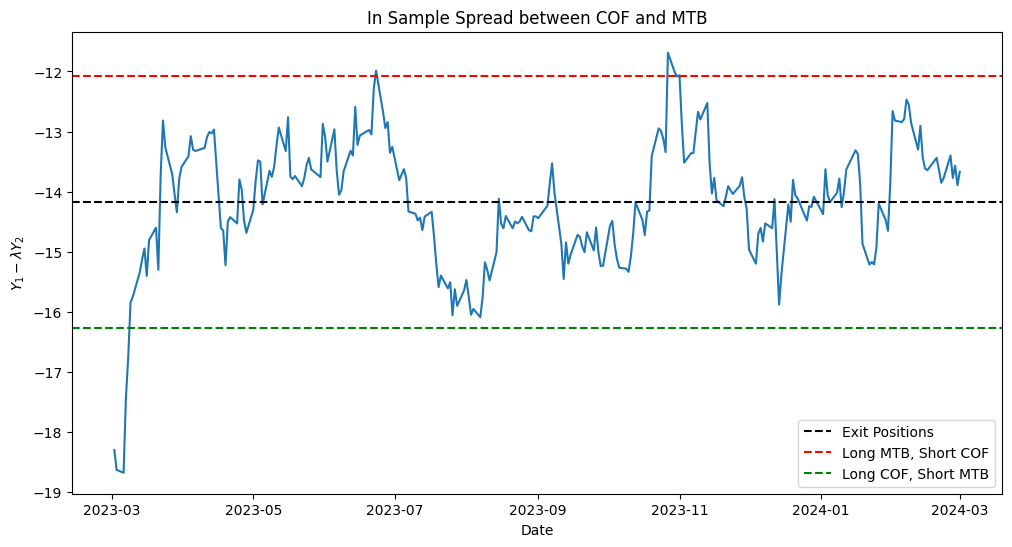

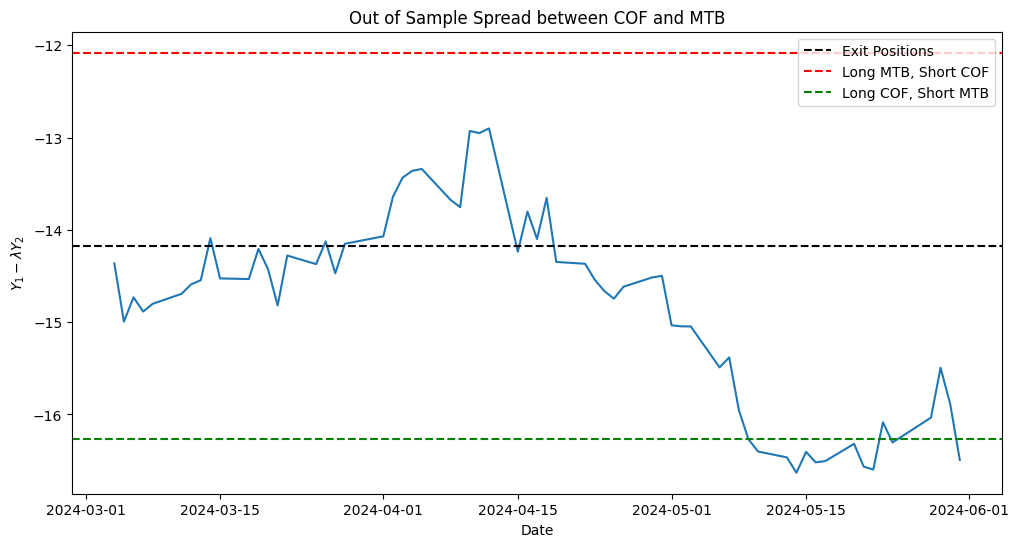

In [80]:
# plot an example spread
n = len(test_prices)-OUT_OF_SAMPLE_PERIOD*2

for pair in sorted_tickers:
    in_sample_data = test_prices[pair].iloc[
        n-IN_SAMPLE_PERIOD : n
    ]
    out_sample_data = test_prices[pair].iloc[n : n+OUT_OF_SAMPLE_PERIOD]

    is_cointegrated, res = johansen_test(in_sample_data)

    if is_cointegrated:
        # plot spread and thresholds using in sample data
        spread = in_sample_data.dot(res['coint_vector'])
        mean = spread.mean()
        std = spread.std()
        upper_threshold = mean + 2*std
        lower_threshold = mean - 2*std
        plot_spread(
            spread,
            res['tickers'],
            upper_threshold,
            lower_threshold,
            mean,
            title=f'In Sample Spread between {res["tickers"][0]} and {res["tickers"][1]}'
        )

        # plot spread and thresholds using out of sample data
        out_sample_spread = out_sample_data.dot(res['coint_vector'])
        plot_spread(
            out_sample_spread,
            res['tickers'],
            upper_threshold,
            lower_threshold,
            mean,
            title=f'Out of Sample Spread between {res["tickers"][0]} and {res["tickers"][1]}'
        )
        break

In [99]:
# walk-forward backtest
STARTING_CASH = 10000
TRANSACTION_COST = 10
INTEREST_RATE = 0.02
DAILY_RATE = INTEREST_RATE / 252
value_history, cash_history = [], []

for i in range(IN_SAMPLE_PERIOD, len(test_prices)-OUT_OF_SAMPLE_PERIOD, OUT_OF_SAMPLE_PERIOD):
    for pair in sorted_tickers:
        in_sample_data = test_prices[pair].iloc[i-IN_SAMPLE_PERIOD:i]
        out_sample_data = test_prices[pair].iloc[i:i+OUT_OF_SAMPLE_PERIOD]

        is_coint, res = johansen_test(in_sample_data)

        if is_coint:
            in_sample_spread = in_sample_data.dot(res['coint_vector'])
            oos_spread = out_sample_data.dot(res['coint_vector'])
            mean = in_sample_spread.mean()
            std = in_sample_spread.std()
            hedge_ratio = np.abs(res['coint_vector'][1]/res['coint_vector'][0])

            # set thresholds
            upper_threshold = 2
            lower_threshold = -2
            exit_threshold = 0

            # calculate z-score
            z_score = (oos_spread - mean) / std
            
            stock_1_shares, stock_2_shares = 0, 0
            cash = STARTING_CASH if len(cash_history) == 0 else cash_history[-1]

            # calculate returns based on z-score
            for n in range(len(z_score)):
                stock_1_price = out_sample_data[pair[0]].iloc[n]
                stock_2_price = out_sample_data[pair[1]].iloc[n]
                curr_z_score = z_score[n]
                
                # long stock 2, short stock 1
                if curr_z_score > upper_threshold and stock_1_shares == 0:
                    stock_1_shares = np.floor(-(cash * 1/hedge_ratio) / stock_1_price)
                    stock_2_shares = np.floor(cash / stock_2_price)
                    cash -= stock_1_shares*stock_1_price + stock_2_shares*stock_2_price + 2*TRANSACTION_COST
                    
                # long stock 1, short stock 2
                elif curr_z_score < lower_threshold and stock_1_shares == 0:
                    stock_1_shares = np.floor(cash / stock_1_price)
                    stock_2_shares = np.floor(-(cash * hedge_ratio) / stock_2_price)
                    cash -= stock_1_shares*stock_1_price + stock_2_shares*stock_2_price + 2*TRANSACTION_COST
                
                # exit any positions on last day
                elif n == len(z_score) - 1:
                    cash += stock_1_shares*stock_1_price + stock_2_shares*stock_2_price
                    stock_1_shares, stock_2_shares = 0, 0
                    
                elif n > 0:
                    last_z_score = z_score[n-1]
                    
                    # exit if crossed exit threshold
                    if last_z_score > exit_threshold and curr_z_score < exit_threshold and stock_1_shares < 0:
                        cash += stock_1_shares*stock_1_price + stock_2_shares*stock_2_price
                        stock_1_shares, stock_2_shares = 0, 0
                        short_days = 0 # reset shorting days
                    elif last_z_score < exit_threshold and curr_z_score > exit_threshold and stock_1_shares > 0:
                        cash += stock_1_shares*stock_1_price + stock_2_shares*stock_2_price
                        stock_1_shares, stock_2_shares = 0, 0
                
                # calculate borrowing cost
                if stock_1_shares < 0:
                    short_value = np.abs(stock_1_shares) * stock_1_price
                    borrow_cost = short_value * DAILY_RATE
                    cash -= borrow_cost
                
                if stock_2_shares < 0:
                    short_value = np.abs(stock_2_shares) * stock_2_price
                    borrow_cost = short_value * DAILY_RATE
                    cash -= borrow_cost
                
                # Calculate portfolio value
                value_history.append(cash + stock_1_shares*stock_1_price + stock_2_shares*stock_2_price)
                cash_history.append(cash)
                
            break
    
returns_history = pd.Series(value_history).pct_change().fillna(0)

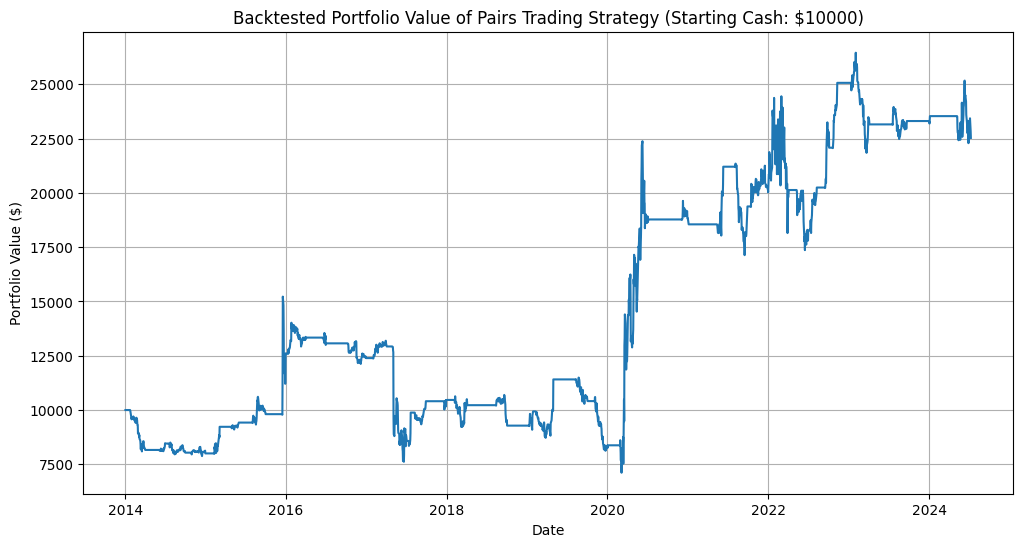

In [100]:
# plot portfolio history
dates = test_prices.iloc[IN_SAMPLE_PERIOD:len(value_history)+IN_SAMPLE_PERIOD].index

plt.figure(figsize=(12, 6))
plt.plot(dates, np.array(value_history))
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title(f'Backtested Portfolio Value of Pairs Trading Strategy (Starting Cash: ${STARTING_CASH})')
plt.grid()
plt.show()

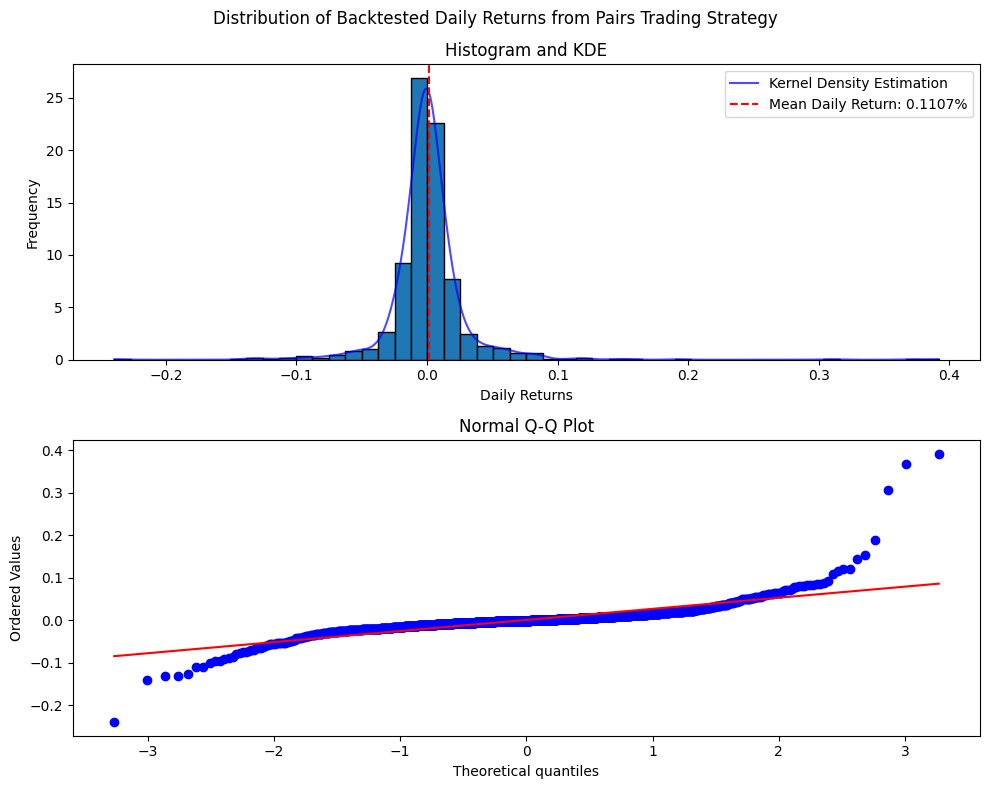

In [78]:
# remove zero returns
nonzero_returns = np.array([r for r in returns_history if r != 0])
mean_return = np.mean(nonzero_returns)
kde = stats.gaussian_kde(nonzero_returns)
x_values = np.linspace(min(nonzero_returns), max(nonzero_returns), 1000)
kde_values = kde(x_values)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# histogram and KDE
axs[0].hist(nonzero_returns, bins=50, density=True, edgecolor='black')
axs[0].plot(x_values, kde_values, color='blue', alpha=0.7, label='Kernel Density Estimation')
axs[0].axvline(mean_return, color='red', linestyle='--', label=f'Mean Daily Return: {100*mean_return:.4f}%')
axs[0].set_xlabel('Daily Returns')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram and KDE')
axs[0].legend()
# QQ plot
stats.probplot(nonzero_returns, dist="norm", plot=axs[1])
axs[1].set_title('Normal Q-Q Plot')

fig.suptitle('Distribution of Backtested Daily Returns from Pairs Trading Strategy')
fig.tight_layout()
fig.show()

In [76]:
standard_deviation = np.std(returns_history)
average_daily_return = stats.gmean(returns_history + 1) - 1

annualized_return = (1 + average_daily_return)**252 - 1
annualized_volatility = standard_deviation * np.sqrt(252)
annual_sharpe_ratio = (annualized_return) / annualized_volatility

print(f'Annualized Returns: {100*annualized_return:.2f}%')
print(f'Annualized Volatility: {100*annualized_volatility:.2f}%')
print(f'Sharpe Ratio: {annual_sharpe_ratio:.2f}')

Annualized Returns: 8.04%
Annualized Volatility: 34.82%
Sharpe Ratio: 0.23
